In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('ggplot')
sns.set_style(rc=plt.rcParams)

In [2]:
from src.parameters import ANIMALS
from loren_frank_data_processing import make_epochs_dataframe
from loren_frank_data_processing import make_neuron_dataframe
from loren_frank_data_processing import get_position_dataframe
from loren_frank_data_processing import get_spikes_dataframe

In [3]:
epoch_info = make_epochs_dataframe(ANIMALS)

In [4]:
epoch_key = ('HPa', 3, 2) # animal, day, epoch
position_info = get_position_dataframe(epoch_key, ANIMALS)

Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [5]:
position_info['time_sec'] = position_info.index / np.timedelta64(1, 's')

In [6]:
neuron_info = make_neuron_dataframe(ANIMALS)
neuron_info = neuron_info.xs(epoch_key, drop_level=False)

In [7]:
def get_position_info_indices_at_spikes(spike_times_sec, position_info):
    '''
    spike_times_sec must be the times in seconds
    position_info must be modified to have a 'time_sec' column with corresponding units to spike_times_sec
    '''
    time_indices = np.empty((spike_times_sec.shape[0]), dtype='int')

    spike_time_index = 0

    for i, spike_time in enumerate(spike_times_sec):
        for index in range(spike_time_index, position_info['time_sec'].shape[0]):
            prev_index = max(0, index-1)
            prev_pos_time = position_info['time_sec'][prev_index]
            pos_time = position_info['time_sec'][index]
            # if we have gone too far
            if pos_time > spike_time:
                spike_time_index = prev_index
                break
        # time_ind (where to index into positions table)
        time_indices[i] = spike_time_index
    return time_indices

In [125]:
def get_combined_dataframe(neuron_info, position_info):
    '''
    Combines all spikes from different neurons with associated position information
    
    Does some copying.
    '''
    # this happens on single core
    df = pd.DataFrame()

    for neuron_idx in range(neuron_info.index.shape[0]):
        neuron_area = neuron_info.iloc[neuron_idx]['area']
        neuron_id = neuron_info.iloc[neuron_idx]['neuron_id']

        spike_times = get_spikes_dataframe(neuron_info.index[neuron_idx], ANIMALS)
        spike_times_sec = spike_times.index / np.timedelta64(1, 's')
        time_indices = get_position_info_indices_at_spikes(spike_times_sec, position_info)

        spike_position_info = position_info.iloc[time_indices].copy()
        spike_position_info['neuron_idx'] = neuron_idx
        spike_position_info['neuron_area'] = neuron_area
        spike_position_info['neuron_id'] = neuron_id
        
        # technically inaccurate, but helps with frequency
        spike_position_info['time_sec'] = spike_times_sec

        df = df.append(spike_position_info)
    return df


In [12]:
# 100ms window
window_sec = 0.100

In [126]:
combined_info = get_combined_dataframe(neuron_info, position_info)

<AxesSubplot:xlabel='time_sec', ylabel='labeled_segments'>

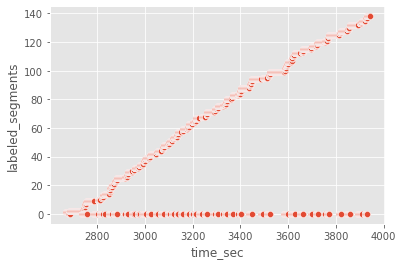

In [51]:
sns.scatterplot(x='time_sec', y='labeled_segments',
               data=position_info)

<AxesSubplot:xlabel='linear_position', ylabel='labeled_segments'>

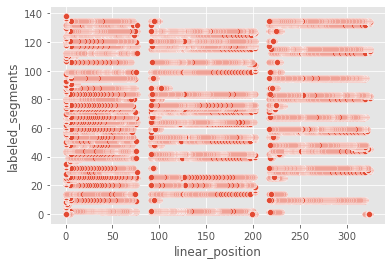

In [52]:
sns.scatterplot(x='linear_position', y='labeled_segments',
               data=position_info)

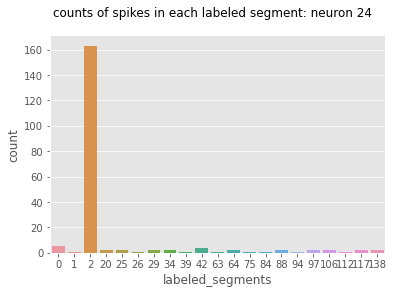

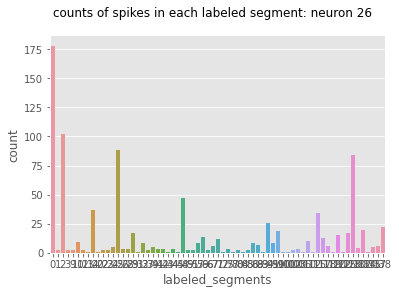

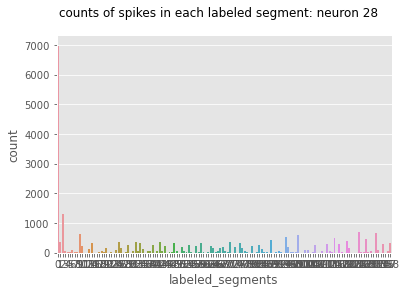

In [59]:
df = combined_info
for i in [24, 26, 28]:
    fig, ax = plt.subplots()
    sns.countplot(x='labeled_segments',
                    data=df[df['neuron_idx'] == i],
                 ax=ax)
    fig.suptitle(f'counts of spikes in each labeled segment: neuron {i}')
    fig.show()

In [43]:
df = combined_info
df = df[df['neuron_idx'] == 24]

<AxesSubplot:xlabel='labeled_segments', ylabel='count'>

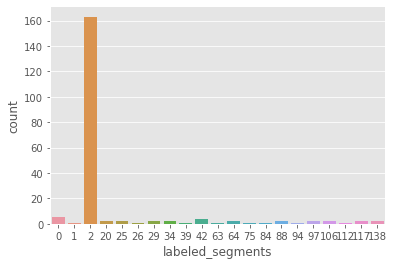

In [48]:
sns.countplot(x='labeled_segments',
            data=df)

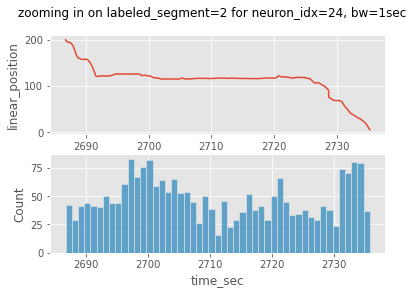

In [68]:
labeled_segments_df = df[df['labeled_segments'] == 2]

fig, ax = plt.subplots(nrows=2, ncols=1)
sns.lineplot(x='time_sec', y='linear_position',
            data=labeled_segments_df,
            ax=ax[0])
sns.histplot(x='time_sec',
            binwidth=1,
            data=labeled_segments_df,
            ax=ax[1])
fig.suptitle(f'zooming in on labeled_segment=2 for neuron_idx=24, bw=1sec')
fig.savefig(f'../figures/neuron_idx_24_labeled_segment_2_hist.png')
fig.show()

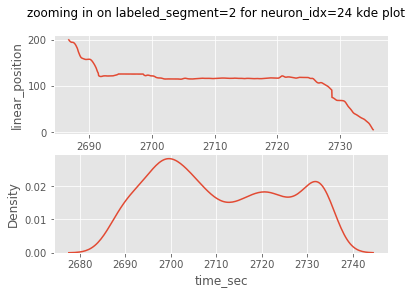

In [67]:
labeled_segments_df = df[df['labeled_segments'] == 2]

fig, ax = plt.subplots(nrows=2, ncols=1)
sns.lineplot(x='time_sec', y='linear_position',
            data=labeled_segments_df,
            ax=ax[0])
sns.kdeplot(x='time_sec',
            data=labeled_segments_df,
            ax=ax[1])
fig.suptitle(f'zooming in on labeled_segment=2 for neuron_idx=24 kde plot')
fig.savefig(f'../figures/neuron_idx_24_labeled_segment_2_kde.png')
fig.show()

In [72]:
neuron_info.iloc[[24, 26, 28]]

spikewidth   meanrate  \
animal day epoch tetrode_number neuron_number                          
HPa    3   2     14             1               10.622981   0.156863   
                 15             1               11.855802   0.708235   
                                3                7.127713  19.420392   

                                               numspikes       csi  \
animal day epoch tetrode_number neuron_number                        
HPa    3   2     14             1                  200.0  0.045000   
                 15             1                  903.0  0.003322   
                                3                24761.0  0.021122   

                                               propbursts  area  \
animal day epoch tetrode_number neuron_number                     
HPa    3   2     14             1                0.150000  iCA1   
                 15             1                0.013289   PFC   
                                3                0.081176   PFC   

                                                       neuron_id  
animal day epoch tetrode_number neuron_number                     
HPa    3   2     14             1              HPa_03_02_014_001  
                 15             1              HPa_03_02_015_001  
                                3              HPa_03_02_015_003

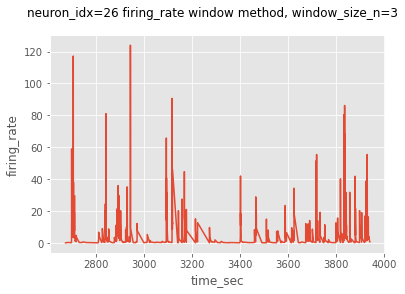

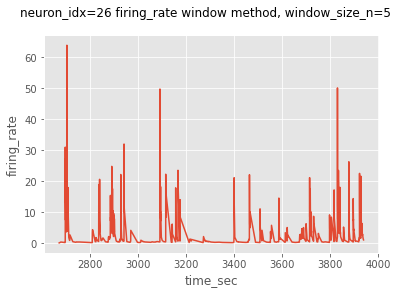

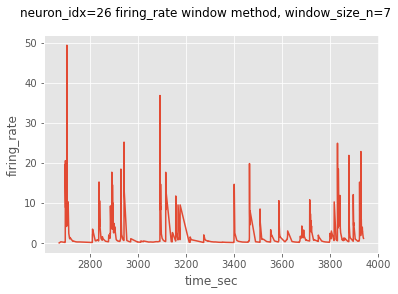

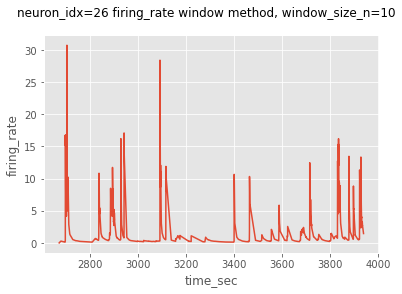

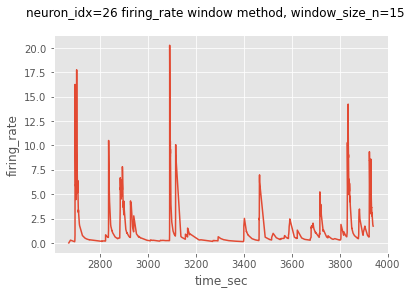

In [151]:
df = combined_info
df = df[df['neuron_idx'] == 26]

firing_rates = np.empty(df.shape[0])

# fixed number first, search backward
for window_size_n in [3, 5, 7, 10, 15]:
#     window_size_n = 10

    for i in range(df.shape[0]):
        bottom = max(0, i+1-window_size_n)
        size = i+1 if bottom == 0 else window_size_n

        bottom_time = df['time_sec'][bottom]
        current_time = df['time_sec'][i]

        time_diff = current_time - bottom_time
        frequency = size / time_diff if size > 1 else 0

        firing_rates[i] = frequency

    df['firing_rate'] = firing_rates

    fig, ax = plt.subplots()
    sns.lineplot(x='time_sec', y='firing_rate',
                 data=df,
                ax=ax)
    fig.suptitle(f'neuron_idx=26 firing_rate window method, window_size_n={window_size_n}')


Text(0.5, 0.98, 'neuron_idx=26 firing_rate window method, window_size_n=15')

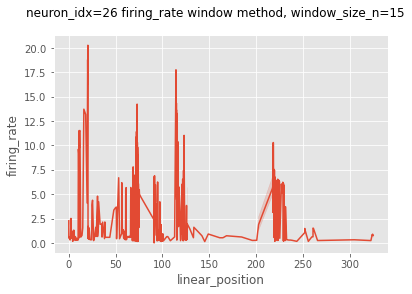

In [152]:
fig, ax = plt.subplots()
sns.lineplot(x='linear_position', y='firing_rate',
             data=df,
            ax=ax)
fig.suptitle(f'neuron_idx=26 firing_rate window method, window_size_n={window_size_n}')


Text(0.5, 0.98, 'neuron_idx=26 firing_rate window method, window_size_n=15')

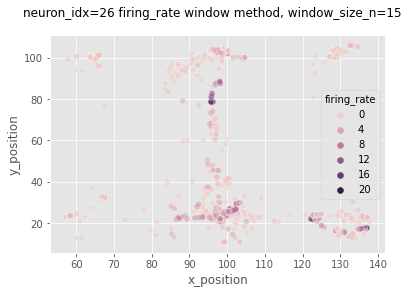

In [160]:
fig, ax = plt.subplots()
sns.scatterplot(x='x_position', y='y_position', hue='firing_rate',
                alpha=0.5,
             data=df,
            ax=ax)
fig.suptitle(f'neuron_idx=26 firing_rate window method, window_size_n={window_size_n}')

<AxesSubplot:xlabel='time_sec', ylabel='Count'>

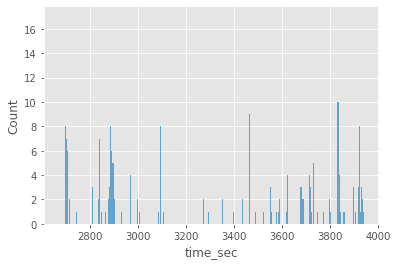

In [140]:
sns.histplot(x='time_sec', y, binwidth=1, data=df)